# <center> *Project – Graph analytics* </center> 
### <center> *M2 Statistics & Econometrics, 2019-2020* </center>
_<center>Marianne HABERT - Pauline CARAMEL - Bruno PILARCZYK - Sarah LAUZERAL</center>_


---

For this project we have at our disposal a dataset containing 220 838 tweets. For each tweets we have plenty informations regarding the author, such as his screen name (twitter id), his status, his number of followers... but also informations concerning the post itself like the time and date of the publication, the number of retweets, the language of the tweet and of course the content of the tweet (text, url...)

The goal of this project is to compute a clustering of tweets in order to regroup individual by opinion (sentiment analysis). Indeed, identifying and regrouping tweets allow us to apprehend positive or negative attitude for a specific marketing action.

---

### 1. Import & explore the data

In [1]:
import pandas as pd
import numpy as np
import unidecode
import os
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import time
import networkx as nx
from networkx.algorithms import bipartite
from scipy import sparse
import community
import itertools
from wordcloud import WordCloud
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#nltk.download('stopwords')
#!pip install python-louvain
#!pip install wordcloud

In [2]:
repsource = "/Users/paulinecaramel/Downloads/Parsing/"

In [3]:
def lect_fichier(rep):
    df = pd.DataFrame()
    
    for _,_,files in os.walk(rep):
        for file in files:
            print(file)
            if df.empty : 
                df = pd.read_csv(rep + file, sep = '\t', quotechar = '"',
                                 low_memory = False)
            else : df = pd.concat([df, pd.read_csv(rep + file, sep = '\t', quotechar='"', 
                                                    low_memory = False)])
    return df   

In [4]:
base_etude = lect_fichier(repsource)

Tweet_01_12_1.txt
Tweet_01_18.txt


/Users/paulinecaramel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


Tweet_01_19.txt
Tweet_01_09.txt
Tweet_01_21.txt
Tweet_01_20.txt
Tweet_01_08.txt
Tweet_01_22.txt
Tweet_01_06.txt
Tweet_01_12.txt
Tweet_01_13.txt
Tweet_01_07.txt
Tweet_01_11.txt
Tweet_01_10.txt
Tweet_01_14.txt
Tweet_01_15.txt
Tweet_01_17.txt
Tweet_01_16.txt


In [5]:
base_etude.head()

,Unnamed: 0,contributors,coordinates,coordinates_coordinates_list,coordinates_type,created_at,display_text_range_list,entities_hashtags_indices,entities_hashtags_text,entities_media_display_url,...,user_profile_sidebar_fill_color,user_profile_text_color,user_profile_use_background_image,user_protected,user_screen_name,user_statuses_count,user_time_zone,user_url,user_utc_offset,user_verified
0,0,None,None,NaN,NaN,Wed Jan 11 23:00:34 +0000 2017,NaN,"[0, 24]",CdiscountOffreLesSoldes,NaN,...,000000,000000,False,False,Sabina2178,194.0,None,None,None,False
1,1,None,None,NaN,NaN,Wed Jan 11 23:00:34 +0000 2017,NaN,"[102, 113]",Soldes2017,NaN,...,000000,000000,False,False,SupRMotard,6200.0,Pacific Time (US & Canada),None,-28800,False
2,2,None,None,NaN,NaN,Wed Jan 11 23:00:35 +0000 2017,NaN,"[102, 113]",Soldes2017,NaN,...,DDEEF6,333333,True,False,Mayzer_RaYzen,953.0,Amsterdam,None,3600,False
3,3,None,None,NaN,NaN,Wed Jan 11 23:00:36 +0000 2017,"[;0;,; ;1;1;1;]",NaN,NaN,pic.twitter.com/R0t8z5u2QP,...,000000,000000,False,False,retropone,7385.0,London,None,0,False
4,4,None,None,NaN,NaN,Wed Jan 11 23:00:37 +0000 2017,NaN,"[50, 58];[64, 75];[98, 123]",XboxOne;Soldes2017;CdiscountOffreMoiUneXbox,NaN,...,C0DFEC,333333,True,False,diasbrandon9,410.0,Paris,None,3600,False


In [49]:
print('Number of languages :', len(base_etude['lang'].unique()))
print('Dimension of the table :', base_etude.shape)

Number of languages : 41
Dimension of the table : (220838, 596)


### 2. Data cleaning

We will now focus on tweets written in french thus the new dataset contains 185 016 tweets.

In [7]:
base_etude_fr = base_etude[base_etude['lang'] == 'fr']

In [8]:
base_etude_fr.shape

(185016, 596)

In [9]:
base_etude.text[0]

0    #CdiscountOffreLesSoldes ça serait trop sympa ...
0    SFR lance un nouveau décodeur TV sans fil, le ...
0    RT @Aro_Bazee: -Sayé madam achete d nouvo talo...
0    RT @cronicaweb: Cruda ola polar en Europa ya s...
0    Nichoir pour les oiseaux nichant dans les cavi...
0    RT @Cdiscount: Vous n'avez pas encore tenté vo...
0    RT @Cdiscount: 🎁 JEU#RT + Follow pour tenter d...
0    @Pamplerouss oui je vois ça. Après les gens s'...
0    RT @jschlickfisch: #PareBrise #innovationOuver...
0    @Nunes_Lola @Cdiscount normal tu as payer ta c...
0    @warwar62 @Cdiscount justement j'allais te dem...
0    RT @Cdiscount: 🎁 JEU#RT + Follow pour tenter d...
0    RT @Cdiscount: @ClichesDeJigme imite @IbraTV_ ...
0    RT @TeamOM_Officiel: 📺 Selon Momo Bouhafsi, le...
0    #CdiscountOffreLesSoldes 🍀💻  https://t.co/LweH...
0    RT @Cdiscount: 🎁 JEU SOLDES RT + Follow @Cdisc...
0    RT @Cdiscount: 🎁 JEU SOLDES RT + Follow @Cdisc...
0    RT @Footballogue: [#Transfert] Selon SFR Sport...
Name: text

To be able to perform a sentiment analysis of tweets we will create a function text_cleaning that will conbined several functions which will apply differents operations to the text:

 - First we need to convert all the tweets characters to lowercase
 - Then we remove punctuation and special characters and replace it by space
 - Afterwards, we tokenize each tweet, which means that we replace the initial tweet by a list containing all its characters
 - Hence, we remove the french stop words such as "comment", "pour", "quoi", "donc", ...
 - And finally we joined back all the remaing words of the initial tweet seperated with space

In [10]:
def convert_text_to_lowercase(df, colname):
    df[colname] = df[colname].str.lower()
    return df
    
def not_regex(pattern):
        return r"((?!{}).)".format(pattern)

def remove_punctuation(df, colname):
    df[colname] = df[colname].str.replace('\n', ' ')
    df[colname] = df[colname].str.replace('\r', ' ')
    df[colname] = df[colname].apply(lambda x: unidecode.unidecode(x))
    alphanumeric_characters_extended = '(\\b[-/]\\b|[a-zA-Z0-9])'
    df[colname] = df[colname].str.replace(not_regex(alphanumeric_characters_extended), ' ')
    return df

def tokenize_sentence(df, colname):
    df[colname] = df[colname].str.split()
    return df

def remove_stop_words(df, colname):
    my_stopwords = stopwords.words('french')
    my_stopwords.remove('pas')
    df[colname] = df[colname].apply(lambda x: [word for word in x if word not in my_stopwords])
    return df

def reverse_tokenize_sentence(df, colname):
    df[colname] = df[colname].map(lambda word: ' '.join(word))
    return df


def text_cleaning(df, colname):
    """
    Takes in a string of text, then performs the following:
    1. convert text to lowercase
    2. remove punctuation and new line characters '\n'
    3. Tokenize sentences
    4. Remove all stopwords
    5. convert tokenized text to text
    """
    df = (
        df
        .pipe(convert_text_to_lowercase, colname)
        .pipe(remove_punctuation, colname)
        .pipe(tokenize_sentence, colname)
        .pipe(remove_stop_words, colname)
        .pipe(reverse_tokenize_sentence, colname)
    )
    return df

In [11]:
df_cleaned = text_cleaning(base_etude_fr, 'text')

/Users/paulinecaramel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/paulinecaramel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/paulinecaramel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

We now have cleaned text to analyze.

Let's now focus on the tweets mentionning mobile operator name to restraint our analysis perimeter.

In [12]:
for operateur in ['free', 'sfr', 'bouygues']:
    print('There are', len(df_cleaned[df_cleaned.text.str.contains(operateur)]),'tweets for', operateur)

There are 2058 tweets for free
There are 29647 tweets for sfr
There are 9038 tweets for bouygues


Let's perform a sentiment analysis on the tweets mentionning the operator sfr in order to understand the general opinion regarding this operator on this social media plateform.

In [13]:
# We select tweet with the word 'sfr'
df_sfr = df_cleaned[['sfr' in k for k in df_cleaned['text']]].reset_index(drop = True)
df_sfr.shape

(29647, 596)

We will delete the retweets not to introduce bias in our analysis because most of the time people retweet fun post or content that they want their followers to see but not necessarily because they agree on the opinion express in the tweet thus we obtain a dataset containing 29 647 distinct tweets.

In [14]:
# We delete retweet
sfr = df_sfr[-df_sfr['text'].str.startswith('rt')].reset_index(drop = True)
sfr.shape

(15842, 596)

In [15]:
sfr['text'][:10]

0    meme pas surpris etes bande connards chez sfr ...
1    maxou17620 freemobile tout cas debit operateur...
2    a tv match kansas oklahoma sfr sport 2 a 00h30...
3    kincartox freemobile oui bon prefere avoir 3g ...
4    sfr 2017 annee reconquete clients https co/vso...
5    maxou17620 freemobile sait chez capter 3g a 10...
6    sfr sav 23h50 reveillez-moi plutot vers 9h mie...
7    angelsl0vess fai voulais dire vas chez sfr num...
8             kincartox bah sfr si https co/yjyjb6ia7e
9    veille https co/ogpgykrjrr gt gt sfr percu com...
Name: text, dtype: object

The tweets are now cleaned and ready to be clusterize.

We will perform 2 kinds of clustering analysis. Firstly, we will implement some hard clustering algorithm such as the KMeans algorithm and then we will implement a soft clustering method like the Louvain algorithm in order to improve our performances.

### 3. Clustering analysis

In order to apply the two algorithms, we select a random sample of 5,000 tweets out of the 15,842. We suppose that this selected tweets are representative. We made this choice because otherwise the Loudain algorithm took too long to run (several hours).

<br>


***3.1) KMeans algorithm***

The K-Means algorithm is a hard clustering techniques which means that it predict the partition of the observations by allocating each tweet to a cluster. To do so this algorithm will assign each observation to a group according to the minimal distance assignment to each barycenter.

In [16]:
texte = sfr['text'].sample(5000, random_state=0) #réduction du nombre de tweets
tfidf_vect = TfidfVectorizer()
tfidf_matrix = tfidf_vect.fit_transform(texte.tolist())

In order to choose the right number of cluster we will plot the number of clusters against the inertia (sum of squared distances of samples to their closest cluster center) and choose the number the number that minimizes the inertia without having a to large number of cluster that is significative of overfitting.

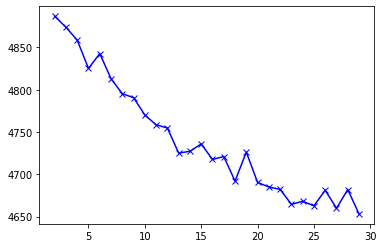

In [17]:
K = range(2,30)
Sum_of_squared_batch = []

for k in K:
    kmeans_batch = MiniBatchKMeans(n_clusters=k, batch_size=256, random_state=0)
    kmeans_batch=kmeans_batch.fit(tfidf_matrix)
    Sum_of_squared_batch.append(kmeans_batch.inertia_)

plt.plot(K, Sum_of_squared_batch, 'bx-')

According to the plot above one can deduce that the best number of cluster is 5 since having more cluster will not allow us to significatively decrease the inertia. Hence let's run the KMeans algorithm with 5 clusters.

In [18]:
num_clusters=5
km = MiniBatchKMeans(n_clusters=num_clusters, batch_size=256, random_state=0)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vect.get_feature_names()

In order to better understand the tweet clustering let's try to visualize the clusters by representing each one by a wordcloud

Cluster 0:

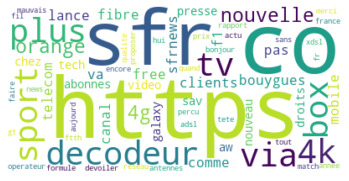

Cluster 1:

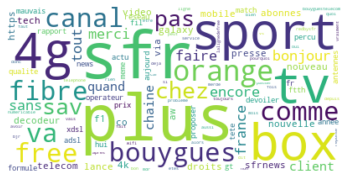

Cluster 2:

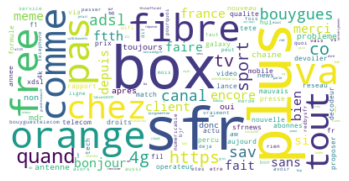

Cluster 3:

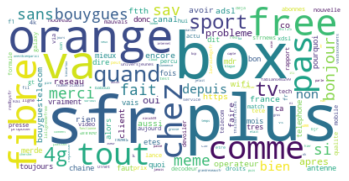

Cluster 4:

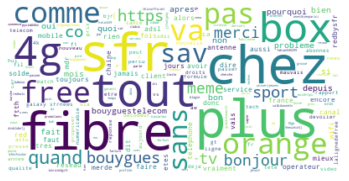

In [19]:
compteur = 0
top_terms = []

for i in range(num_clusters):
    compteur = compteur + 1
    print("Cluster %d:" % i, end='')
    
    for ind in order_centroids[i, :70]:
        popular_terms = terms[ind]
        top_terms.append(popular_terms)
    
    top_cluster = ' '.join(word for word in top_terms)
    wordcloud = WordCloud(background_color="white").generate(top_cluster)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

 - **Cluster 0:** This cluster regoups tweets from individual talking about their connection propably to see match.
 - **Cluster 1:** This cluster is about sport and TV in sfr package.
 - **Cluster 2:** This cluster is exclusively about sport.
 - **Cluster 3:** This cluster seems to regroups sfr client.
 - **Cluster 4:** Finally this cluster is more about internet.


Since this clustering isn't really discriminatory we will implement the Louvain algorithm.

***3.2) Louvain algorithm***

The Louvain method for community detection is a method to extract communities from large networks. The inspiration for this method of community detection is the optimization of modularity as the algorithm progresses. The modularity measures the density of edges inside communities to edges outside communities. Optimizing this value theoretically results in the best possible grouping of the nodes of a given network, however going through all possible iterations of the nodes into groups is impractical so heuristic algorithms are used.

Hence to run the louvain algorithm we must our tfidf_matrix into a graph.

In [20]:
G = bipartite.matrix.from_biadjacency_matrix(tfidf_matrix)

In [21]:
print("Number of nodes :", len(list(G.nodes(data=True))))
print("Number of edges :", len(list(G.edges(data=True))))
print(np.shape(tfidf_matrix))

Number of nodes : 16169
Number of edges : 54824
(5000, 11169)


In [22]:
top_nodes = {n for n, d in G.nodes(data=True) if d['bipartite']==0}

In [23]:
debt = time.time()
G_tweets = bipartite.projection.weighted_projected_graph(G, nodes=top_nodes, ratio=False)
print(time.time()-debt)

176.7762291431427


In [24]:
partition = community.best_partition(G_tweets, random_state=0)
clusters = pd.Series(partition)

In [25]:
counts = list(clusters.value_counts()[clusters.value_counts()>1].index)
clusters = clusters[clusters.map(lambda x: x in counts)]

Once we perform the louvain algorithm and classify our tweets we will create a dataframe associating each tweet to its cluster.

In [26]:
text = pd.DataFrame(texte).reset_index()
clust = pd.DataFrame.from_dict(partition, orient='index')
cluster_matrix = pd.concat([text, clust], axis=1).rename(columns={"text": "Tweet", 0: "Cluster"}).drop("index", 1)
cluster_matrix.head()

,Tweet,Cluster
0,sebcas59 recommande utiliser reseau sfr wifi p...,0
1,france sfr lance decodeur plus sfr nouvelle bo...,0
2,sfr red 10 go 10 euros forfait illimite https ...,0
3,red by sfr forfait 10 go 10EUR mois a vie http...,0
4,sfr sav toujours pas nouvelle sfr tv sous wind...,1


In [27]:
NbClusters = len(set(clusters.values))
Words_cluster0 = []
Words_cluster1 = []
Words_cluster2 = []

for i in range(NbClusters):
    df_cluster = cluster_matrix.loc[cluster_matrix["Cluster"] == i].reset_index()
    tokenize_sentence(df_cluster, "Tweet")
    print("Number of tweets in cluster %d: " % i, end='')
    print(df_cluster.shape[0])
    for j in range(len(df_cluster)):
        if i == 0:
            row = df_cluster["Tweet"][j]
            Words_cluster0.append(row)
        elif i == 1:
            row = df_cluster["Tweet"][j]
            Words_cluster1.append(row)
        else:
            row = df_cluster["Tweet"][j]
            Words_cluster2.append(row)

Number of tweets in cluster 0: 1693
Number of tweets in cluster 1: 3307


The loop above created as many lists as there are clusters and fill them with all the words contained in all the tweets belonging to each cluster. Moreover one can notice that the clusters are fairly unbalanced however it doesn't matter since the best partition only create 2 clusters.

Let's check each observation has been treated:

In [28]:
len(Words_cluster0) + len(Words_cluster1) == 5000

True

#### Let's focus on the cluster 0

With the lists created above we will create a dataframe with each unique word in the cluster, the number of times it appears in the cluster and its freaquency (in percentage).

In [29]:
Words_cluster0 = list(itertools.chain.from_iterable(Words_cluster0))
NbWords0 = len(Words_cluster0)
Words_cluster = pd.DataFrame(Words_cluster0).rename(columns={0: "Word"})
TopWords0 = Words_cluster["Word"].value_counts().rename_axis('unique_words').reset_index(name='counts')
total = TopWords0["counts"].sum()
TopWords0["Freq"] = TopWords0["counts"]/total * 100
TopWords0.head()

,unique_words,counts,Freq
0,https,1925,9.229515
1,sfr,1827,8.759649
2,a,569,2.728101
3,plus,267,1.280146
4,sport,251,1.203433


From the dataframe created above we plotted a wordcloud. This cloud doesn't seem easy to interpret but it probably regoups tweets about connection...

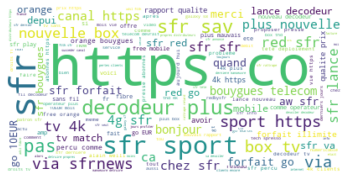

In [30]:
top_cluster0 = ' '.join(word for word in Words_cluster0)
wordcloud = WordCloud(background_color="white").generate(top_cluster0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Now we will take a look at the cluster 1

As previously we created a dataframe with the unique words in this cluster, their count and their frequency of apparition.

In [31]:
Words_cluster1 = list(itertools.chain.from_iterable(Words_cluster1))
NbWords1 = len(Words_cluster1)
Words_cluster = pd.DataFrame(Words_cluster1).rename(columns={0: "Word"})
TopWords1 = Words_cluster["Word"].value_counts().rename_axis('unique_words').reset_index(name='counts')
total = TopWords1["counts"].sum()
TopWords1["Freq"] = TopWords1["counts"]/total * 100
TopWords1.head()

,unique_words,counts,Freq
0,sfr,4075,11.026328
1,a,1154,3.122548
2,pas,839,2.270206
3,sav,526,1.423276
4,chez,502,1.358335


This cluster seems to regroup tweets regarding the after-sale services, thus this cluster mainly regoups sfr clients.

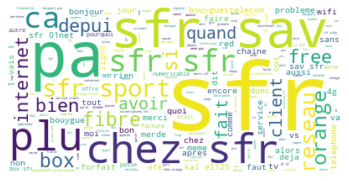

In [32]:
top_cluster1 = ' '.join(word for word in Words_cluster1)
wordcloud = WordCloud(background_color="white").generate(top_cluster1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### 4. Improvements

***4.1) KMeans algorithm***

One can notice that there are words in differents clusters that repeat themselves thus one can deduce that these words aren't extremely discriminant to classify a tweet in a cluster therefore we will eliminate the common words in all clusters.

Once this new cleaning has been done to the tweets we will again applied the 2 clustering methods implemented previously.

In [33]:
#print(list(set(TopWords0["unique_words"]) & set(TopWords1["unique_words"]))) 
word_delete = ['a', 'achete', 'actualita', 'aller', 'alors', 'anna', 'apres', 'assa', 'aussi', 'avant', 'avoir', 
               'bonjour', 'ca', 'car', 'chez', 'co', 'comme', 'comment',  'da', 'deja', 'depuis', 'devant', 'dit',
               'dire', 'donc', 'e', 'encore', 'entre', 'faire', 'faut', 'fait', 'fr', 'https', 'pas', 'pa', 
               'plus', 'puis', 'quand', 'quoi', 'ra', 're', 'sait', 'selon', 'seau', 'sfr', 'si', 'tous', 'tout', 
               'tres', 'va', 'vais', 'veut', 'via', 'voir', 'vraiment', 'zdnetfr']
CleanText = texte.str.split().apply(lambda x: [word for word in x if word not in word_delete])
CleanText = CleanText.map(lambda word: ' '.join(word))
texte2 = CleanText.sample(5000, random_state=0)

In [34]:
tfidf_vect2 = TfidfVectorizer()
tfidf_matrix2 = tfidf_vect2.fit_transform(texte2.tolist())

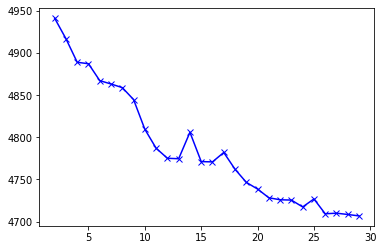

In [35]:
K = range(2,30)
Sum_of_squared_batch = []

for k in K:
    kmeans_batch = MiniBatchKMeans(n_clusters=k, batch_size=256, random_state=0)
    kmeans_batch=kmeans_batch.fit(tfidf_matrix2)
    Sum_of_squared_batch.append(kmeans_batch.inertia_)

plt.plot(K, Sum_of_squared_batch, 'bx-')

In [36]:
num_clusters=3
km2 = MiniBatchKMeans(n_clusters=num_clusters, batch_size=256, random_state=0)
km2.fit(tfidf_matrix2)
clusters = km2.labels_.tolist()
order_centroids2 = km2.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vect2.get_feature_names()

Cluster 0:

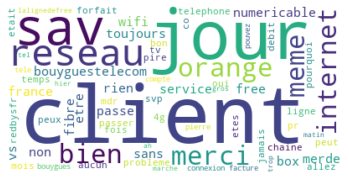

Cluster 1:

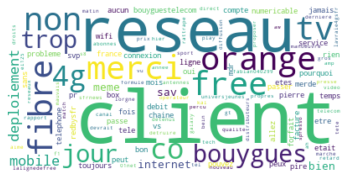

Cluster 2:

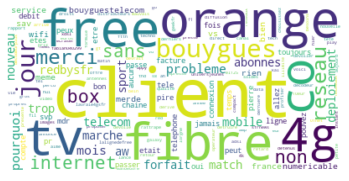

In [37]:
compteur = 0
top_terms = []

for i in range(num_clusters):
    compteur = compteur + 1
    print("Cluster %d:" % i, end='')
    
    for ind in order_centroids2[i, :70]:
        popular_terms = terms[ind]
        top_terms.append(popular_terms)
    
    top_cluster = ' '.join(word for word in top_terms)
    wordcloud = WordCloud(background_color="white").generate(top_cluster)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

 - **Cluster 0:** This cluster regroups tweets about bad customer experience of their wifi connection.
 - **Cluster 1:** This cluster concerns more mobile network and their competitors.
 - **Cluster 2:** Finally, the last cluster regroups tweets about TV & internet.

***4.2) Louvain algorithm***

In [38]:
G2 = bipartite.matrix.from_biadjacency_matrix(tfidf_matrix)

In [39]:
top_nodes = {n for n, d in G2.nodes(data=True) if d['bipartite']==0}

In [40]:
debt = time.time()
G_tweets2 = bipartite.projection.weighted_projected_graph(G2, nodes=top_nodes, ratio=False)
print(time.time()-debt)

204.87368822097778


In [41]:
partition2 = community.best_partition(G_tweets2, random_state=0)
clusters = pd.Series(partition2)

In [42]:
counts = list(clusters.value_counts()[clusters.value_counts()>1].index)
clusters = clusters[clusters.map(lambda x: x in counts)]

In [43]:
text2 = pd.DataFrame(texte2).reset_index()
clust2 = pd.DataFrame.from_dict(partition2, orient='index')
cluster_matrix2 = pd.concat([text2, clust2], axis=1).rename(columns={"text": "Tweet", 0: "Cluster"}).drop("index", 1)
cluster_matrix2.head()

,Tweet,Cluster
0,aime video youtube toniooinot31 niang sport an...,0
1,leblogdelaura netflixfr chrome cast bien facil...,0
2,sav numero fonctionne 1 repondeur indique 01/0...,0
3,thizsofficiel sav 1800,0
4,brunomglhs toute mifa aucune plainte,1


In [44]:
NbClusters = len(set(clusters.values))
Words_cluster0 = []
Words_cluster1 = []

for i in range(NbClusters):
    df_cluster = cluster_matrix2.loc[cluster_matrix2["Cluster"] == i].reset_index()
    tokenize_sentence(df_cluster, "Tweet")
    print("Number of tweets in cluster %d: " % i, end='')
    print(df_cluster.shape[0])
    for j in range(len(df_cluster)):
        if i == 0:
            row = df_cluster["Tweet"][j]
            Words_cluster0.append(row)
        else:
            row = df_cluster["Tweet"][j]
            Words_cluster1.append(row)

Number of tweets in cluster 0: 1693
Number of tweets in cluster 1: 3307


#### Let's focus on the cluster 0

In [45]:
Words_cluster0 = list(itertools.chain.from_iterable(Words_cluster0))
NbWords0 = len(Words_cluster0)
Words_cluster = pd.DataFrame(Words_cluster0).rename(columns={0: "Word"})
TopWords0 = Words_cluster["Word"].value_counts().rename_axis('unique_words').reset_index(name='counts')
total = TopWords0["counts"].sum()
TopWords0["Freq"] = TopWords0["counts"]/total * 100
TopWords0.head()

,unique_words,counts,Freq
0,sav,224,1.583822
1,sport,156,1.103019
2,box,131,0.926253
3,orange,117,0.827264
4,free,87,0.615145


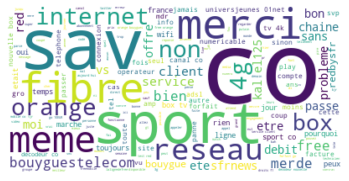

In [46]:
top_cluster0 = ' '.join(word for word in Words_cluster0)
wordcloud = WordCloud(background_color="white").generate(top_cluster0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Now we will take a look at the cluster 1

In [47]:
Words_cluster1 = list(itertools.chain.from_iterable(Words_cluster1))
NbWords1 = len(Words_cluster1)
Words_cluster = pd.DataFrame(Words_cluster1).rename(columns={0: "Word"})
TopWords1 = Words_cluster["Word"].value_counts().rename_axis('unique_words').reset_index(name='counts')
total = TopWords1["counts"].sum()
TopWords1["Freq"] = TopWords1["counts"]/total * 100
TopWords1.head()

,unique_words,counts,Freq
0,sav,428,1.534930
1,sport,353,1.265959
2,box,280,1.004160
3,orange,267,0.957538
4,tv,202,0.724430


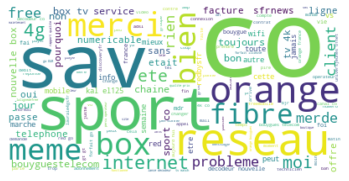

In [48]:
top_cluster1 = ' '.join(word for word in Words_cluster1)
wordcloud = WordCloud(background_color="white").generate(top_cluster1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Once again the Louvain algorithm seems to show poor results, indeed both wordclouds almost identical...